In [1517]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [1518]:
#load data
data = pd.read_csv('./train.csv')
print(f"Data shape: {data.shape}")

Data shape: (42000, 785)


In [1519]:
#split X and y
data = data.to_numpy()
np.random.shuffle(data)

X = data[:, 1:].T
y = data[:, 0]

d, N = X.shape

print(f"Shape of the matrix X: {X.shape} \nShape of the matrix y: {y.shape}")
print(f"Number of features: {d} \nNumber of images: {N}")

Shape of the matrix X: (784, 42000) 
Shape of the matrix y: (42000,)
Number of features: 784 
Number of images: 42000


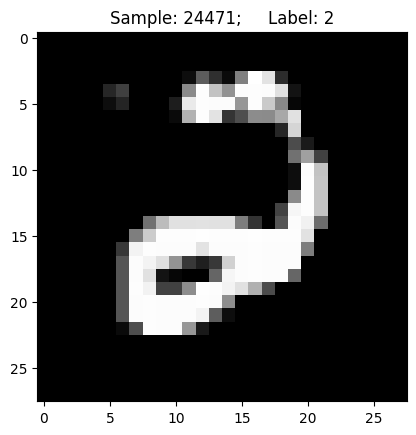

In [1520]:
def visualize(X, Y, idx):

    img = X[:, idx].reshape((28,28))

    plt.imshow(img, cmap='gray')
    plt.title(f"Sample: {idx};     Label: {Y[idx]}")
    plt.show()

idx = np.random.randint(0, N+1)
visualize(X, y, idx)

In [1521]:
C1, C2 = 3,4
idxs = (y==C1) | (y==C2) # create a True/False array
filteredX = X[:, idxs] # return all the columns of X in which idxs is true
filteredY = y[idxs]
print(f"Filtered X shape: {filteredX.shape}")
print(f"Filtered Y shape: {filteredY.shape}")

Filtered X shape: (784, 8423)
Filtered Y shape: (8423,)


In [1522]:
def split_data(X, y, train_size):
    _, N = X.shape # assumes data with shape (d, N)
    
    idxs = np.arange(N)
    np.random.shuffle(idxs)

    N_train = int(train_size*N) #number of training samples

    train_idxs = idxs[:N_train]
    test_idxs = idxs[N_train:]

    Xtrain, Xtest, ytrain, ytest = X[:, train_idxs], X[:, test_idxs], y[train_idxs], y[test_idxs]

    return Xtrain, Xtest, ytrain, ytest

#split data in train and test
Xtrain, Xtest, ytrain, ytest = split_data(filteredX, filteredY, train_size=0.8)

print(f"Xtrain shape: {Xtrain.shape} --- Xtest shape: {Xtest.shape}  \nytrain shape: {ytrain.shape} --- ytest shape: {ytest.shape}")


Xtrain shape: (784, 6738) --- Xtest shape: (784, 1685)  
ytrain shape: (6738,) --- ytest shape: (1685,)


In [1523]:
X1 = Xtrain[:, ytrain==C1]
X2 = Xtrain[:, ytrain==C2]

In [1524]:
# When full_matrices=False, VT is returned with shape min(m,n) x n. V is reduced to contain 
# only the columns or rows corresponding to non-zero singular values
U1, s1, VT1 = np.linalg.svd(X1, full_matrices=False)
print(U1.shape, s1.shape, VT1.shape)

U2, s2, VT2 = np.linalg.svd(X2, full_matrices=False)
print(U2.shape, s2.shape, VT2.shape)

(784, 784) (784,) (784, 3473)
(784, 784) (784,) (784, 3265)


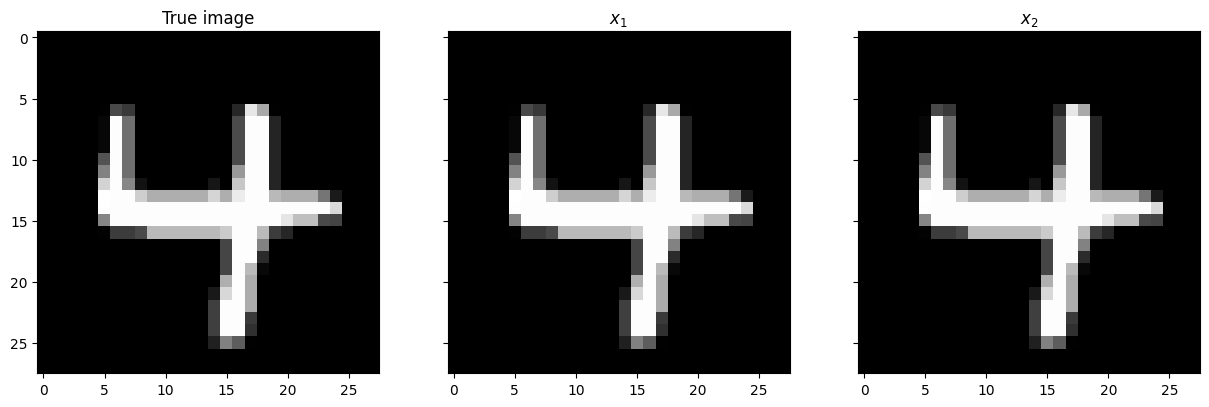

In [1525]:
#np.random.seed(42)
idx = np.random.randint(0, Xtest.shape[0])
x = Xtest[:, idx] #x.shape = (784,)
x1 = U1@(U1.T@x) # project x through U1
x2 = U2@(U2.T@x) # project x through U2


fig, axs = plt.subplots(figsize=(15,30), nrows=1, ncols=3, sharey=True)
ax = axs[0]
ax.imshow(x.reshape((28,28)), cmap='gray')
ax.set_title('True image')
ax = axs[1]
ax.imshow(x1.reshape((28,28)), cmap='gray')
ax.set_title('$x_1$')
ax = axs[2]
ax.imshow(x2.reshape((28,28)), cmap='gray')
ax.set_title('$x_2$')
plt.show()


The images $x_1$ and $x_2$ obtained by projecting the real image, are very similar to the original one $x$. Indeed, the distances computed in the next cell are very small.

In [1526]:
d1 = np.linalg.norm(x-x1, 2)
d2 = np.linalg.norm(x-x2, 2)
print(f'd1 = {d1} \nd2 = {d2}')

pred = C2 if d1>d2 else C1
print(f'Predicted class: {pred}')

d1 = 5.126895170425466e-12 
d2 = 3.69631547590965e-12
Predicted class: 4


In [1527]:
# We now project the entire test set
x1 = U1@(U1.T@Xtest) 
x2 = U2@(U2.T@Xtest)
print(x1.shape)


d1 = np.linalg.norm(Xtest-x1, 2, axis=0) # 1-dimensional array of shape (1685,)
d2 = np.linalg.norm(Xtest-x2, 2, axis=0)


pred = np.where(d1 > d2, C2, C1) # 1-dimensional array


(784, 1685)


In [1528]:
accuracy = np.mean(pred == ytest)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 80.77%


The following function compute the the SVD classification for two arbitrary digits $\textit{class1}$ and $\textit{class2}$. It returns the accuracy of classification for the two given digits.

In [1549]:
def SVD_classifier_2classes(data, labels, class1, class2, train_size):

    #filter the dataset given the classes
    C1, C2 = class1, class2
    idxs = (labels==C1) | (labels==C2)
    filteredX = data[:, idxs]
    filteredY = labels[idxs]

    #split data
    Xtrain, Xtest, ytrain, ytest = split_data(filteredX, filteredY, train_size)

    #obtain two subsets of the data each of them containing only observations of a specific class
    X1 = Xtrain[:, ytrain==C1]
    X2 = Xtrain[:, ytrain==C2]

    #SVD decomposition
    U1, s1, VT1 = np.linalg.svd(X1, full_matrices=False)
    U2, s2, VT2 = np.linalg.svd(X2, full_matrices=False)

    #projection
    x1 = U1@(U1.T@Xtest)
    x2 = U2@(U2.T@Xtest)


    #compute distances
    d1 = np.linalg.norm(Xtest-x1,2, axis=0)
    d2 = np.linalg.norm(Xtest-x2,2, axis=0)

    #predict
    pred = np.where(d1 >= d2, C2, C1)
    
    #compute the accuracy
    accuracy = np.mean(pred == ytest)

    return pred, accuracy

# we now use the classifier for each pair of digits
digits = np.unique(y)
pairs = [(i,j) for i in digits for j in digits if i<j]

accuracy_list = []

for digit1, digit2 in pairs:
    _, accuracy = SVD_classifier_2classes(X, y, class1=digit1, class2=digit2, train_size=0.67)
    accuracy_list.append((digit1, digit2,accuracy)) # list of tuples

#build a 10x10 matrix with accuracies
accuracy_matrix = np.zeros((10, 10))
np.fill_diagonal(accuracy_matrix,1)
for digit1, digit2, accuracy in accuracy_list:
    accuracy_matrix[digit1, digit2] = accuracy
    accuracy_matrix[digit2, digit1] = accuracy #symmetric matrix

    

In the previous cell has been computed the SVD classification for each pair of digits. The following graph shows the heatmap associated with the experiment: each item of the heatmap represents the accuracy of the SVD classification performed on the digits $i, j$ where $i \in [0...9]$ and $j \in [0...9]$

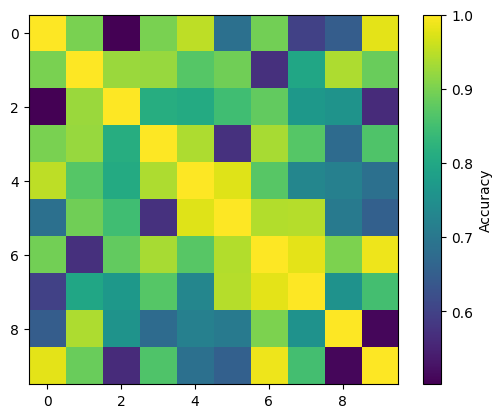

In [1550]:
plt.imshow(accuracy_matrix, interpolation="nearest", cmap="viridis")
plt.colorbar(label="Accuracy")
plt.show()

The heatmap shows that the algorithm is more accurate with visually different digits (like 0 and 1 for example). It is less accurate with visually similar digits

The following function compute the the SVD classification for $n$ arbitrary digits. The digits must be specified in the parameter $\textit{classes}$ that must be a numpy array. The function returns the accuracy of classification for the given digits.

In [1552]:
def SVD_classifier_kclasses(data, labels, classes, train_size):

    #filter data
    mask = np.isin(labels, classes) # check if each element in the array labels belongs to classes. Shape (N,)
    filteredX = data[:, mask]
    filteredY = labels[mask]

    #split data (entire dataset)
    Xtrain, Xtest, ytrain, ytest = split_data(filteredX, filteredY, train_size)

    distances = []

    for c in classes:

        X_c_train = Xtrain[:, ytrain==c] # take all the training samples of class c

        U, s, VT = np.linalg.svd(X_c_train, full_matrices=False) #SVD decomposition

        x_c_proj = U@(U.T@Xtest) # projection

        d = np.linalg.norm(Xtest-x_c_proj, 2, axis=0) # compute distances
        distances.append(d) # append the vector d to the vector distances
    
    distances = np.array(distances) # shape: (num_classes, num_samples)

    min_indices = np.argmin(distances, axis=0) # for each column argmin takes the INDEX of the row with minimum value, shape: (num_samples)
    pred = classes[min_indices] # shape (num_samples.)

    accuracy = np.mean(pred == ytest)

    return accuracy

pred012 = []
pred497 = []

for i in range(30): #repeat the experiment 30 times to get the avarage
    pred012.append(SVD_classifier_kclasses(X, y, np.array([0,1,2]), 0.8))
    pred497.append(SVD_classifier_kclasses(X, y, np.array([4,9,7]), 0.8))
    
print(f'Avarage accuracy on classes 1, 2, 0 is {(np.mean(np.array(pred012)))*100:.2f}%')
print(f'Avarage accuracy on classes 4,9,7 is {(np.mean(np.array(pred497)))*100:.2f}%')

Avarage accuracy on classes 1, 2, 0 is 71.00%
Avarage accuracy on classes 4,9,7 is 53.21%


### As we can see from the example above, if we choose 3 digits quite different each other (as 0, 1 and 2) we obtain a better accuracy compared with the case in which we choose 3 digits similar each other. In particular, if we visualize some images showing the number 4 and and the number 9, we can see they are almost the same. As a consequence, the SVD classifier has a very poor accuracy when using classes 4, 9 and 7.